# Libraries

In [2]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import seaborn as sns

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Size and Directory Path

In [3]:
img_width, img_height = 224, 224
num_classes = 11
batch_size = 32
dataset_dir = "/content/drive/My Drive/Dataset_balance"

# Model Building

In [4]:
base_model = DenseNet121(weights = 'imagenet', include_top =False, input_shape=(img_width, img_height, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [5]:
for layer in base_model.layers:
  layer.trainable = False

In [6]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

In [7]:
model = Model(
    inputs=base_model.input, 
    outputs=predictions
    )

In [8]:
model.compile(
    optimizer='adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
    )

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Pre-Process Data using ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
  )

In [11]:
train_data = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 11044 images belonging to 11 classes.


In [12]:
train_data.class_indices

{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Late_blight': 2,
 'Leaf_Mold': 3,
 'Septoria_leaf_spot': 4,
 'Spider_mites Two-spotted_spider_mite': 5,
 'Target_Spot': 6,
 'Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato_mosaic_virus': 8,
 'healthy': 9,
 'powdery_mildew': 10}

In [13]:
train_data.image_shape

(224, 224, 3)

In [14]:
val_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
val_data = val_datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 1375 images belonging to 11 classes.


# Visualizing Data

<Axes: xlabel='labels', ylabel='count'>

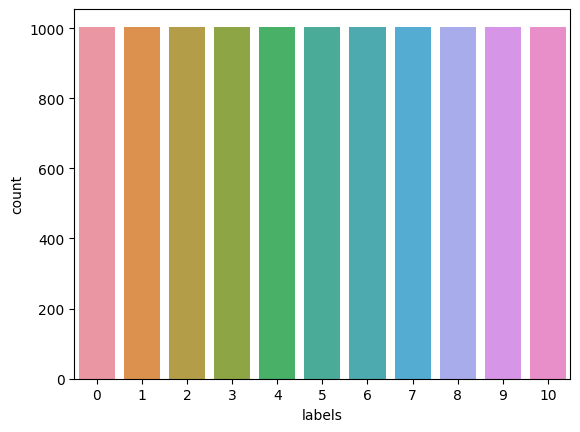

In [16]:
labelDf = pd.DataFrame(train_data.labels)
labelDf.rename(columns = {0:'labels'}, inplace = True)

sns.countplot(data=labelDf, x='labels')

# Model Checkpoint

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint(filepath= "/content/drive/My Drive/denseNet11Classes.h5", 
                     monitor  = "val_accuracy", 
                     verbose = 1, 
                     save_best_only= True)

In [19]:
his = model.fit(
    train_data,
    steps_per_epoch = batch_size,
    epochs = 40,
    validation_data = val_data,
    validation_steps = batch_size,
    callbacks = [mc]
)

Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 29.6932 - accuracy: 0.3105
Epoch 1: val_accuracy improved from -inf to 0.47754, saving model to /content/drive/My Drive/denseNet11Classes.h5
32/32 [==============================] - 474s 14s/step - loss: 29.6932 - accuracy: 0.3105 - val_loss: 3.6132 - val_accuracy: 0.4775
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 1.2802 - accuracy: 0.6729
Epoch 2: val_accuracy improved from 0.47754 to 0.72363, saving model to /content/drive/My Drive/denseNet11Classes.h5
32/32 [==============================] - 285s 9s/step - loss: 1.2802 - accuracy: 0.6729 - val_loss: 0.9368 - val_accuracy: 0.7236
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.8037
Epoch 3: val_accuracy improved from 0.72363 to 0.80176, saving model to /content/drive/My Drive/denseNet11Classes.h5
32/32 [==============================] - 200s 6s/step - loss: 0.6638 - accuracy: 0.8037 - val_loss: 0.6267 

In [20]:
from tensorflow.keras.models import load_model

In [21]:
model = load_model("/content/drive/MyDrive/denseNet11Classes.h5")

In [ ]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [22]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

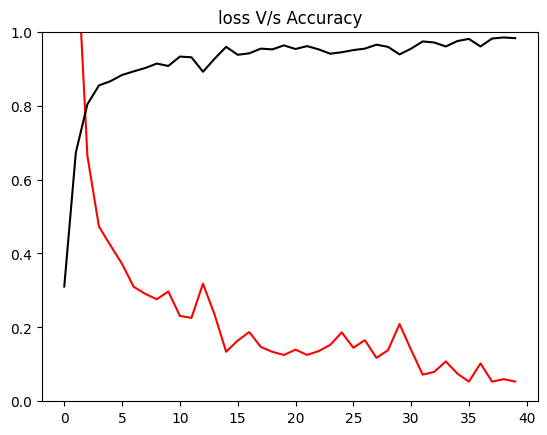

In [23]:
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "k")
plt.ylim((0, 1))
plt.title("loss V/s Accuracy")
plt.show()

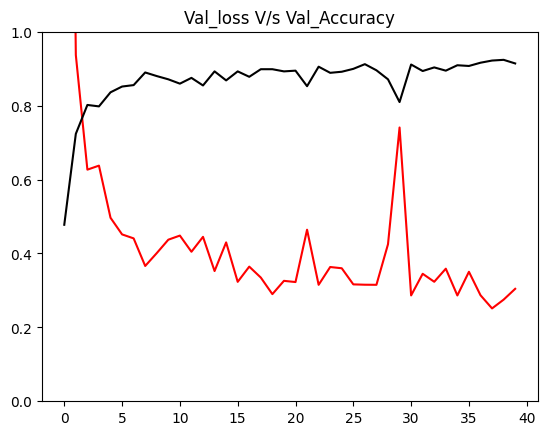

In [24]:
plt.plot(h['val_loss'], "r")
plt.plot(h['val_accuracy'], "k")
plt.ylim((0, 1))
plt.title("Val_loss V/s Val_Accuracy")
plt.show()

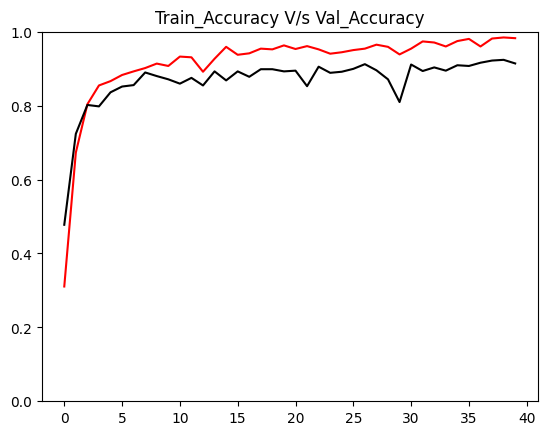

In [25]:
plt.plot(h['accuracy'], "r")
plt.plot(h['val_accuracy'], "k")
plt.ylim((0, 1))
plt.title("Train_Accuracy V/s Val_Accuracy")
plt.show()

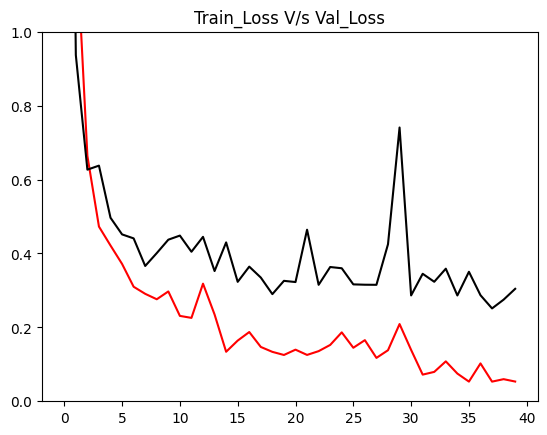

In [26]:
plt.plot(h['loss'], "r")
plt.plot(h['val_loss'], "k")
plt.ylim((0, 1))
plt.title("Train_Loss V/s Val_Loss")
plt.show()